
Reporte de Clasificación:
              precision    recall  f1-score   support

         acc       0.56      0.81      0.66       118
        good       0.60      0.32      0.41        19
       unacc       0.95      0.86      0.90       358
       vgood       0.82      0.38      0.51        24

    accuracy                           0.81       519
   macro avg       0.73      0.59      0.62       519
weighted avg       0.84      0.81      0.81       519



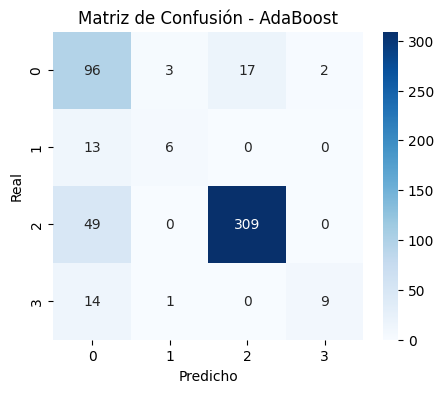

Multiclass ROC AUC score: 0.91


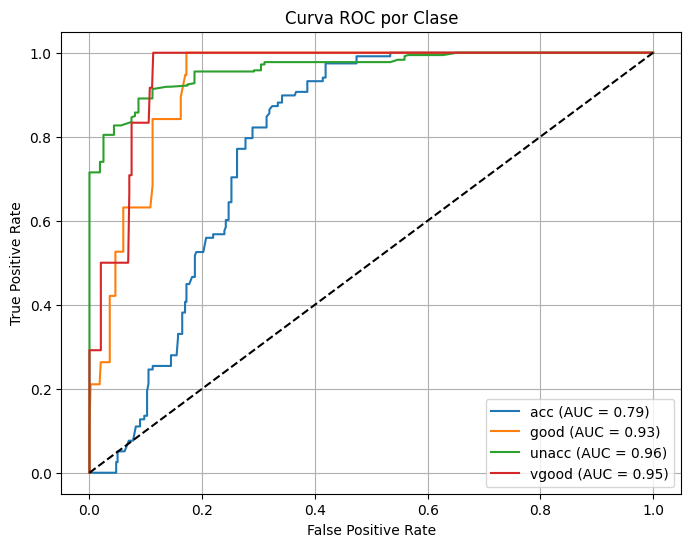


Mejores Hiperparámetros: {'learning_rate': 1.0, 'n_estimators': 100}
Precisión con los mejores parámetros: 0.8400770712909441

Precisión Promedio con Validación Cruzada: 0.7459545949568568


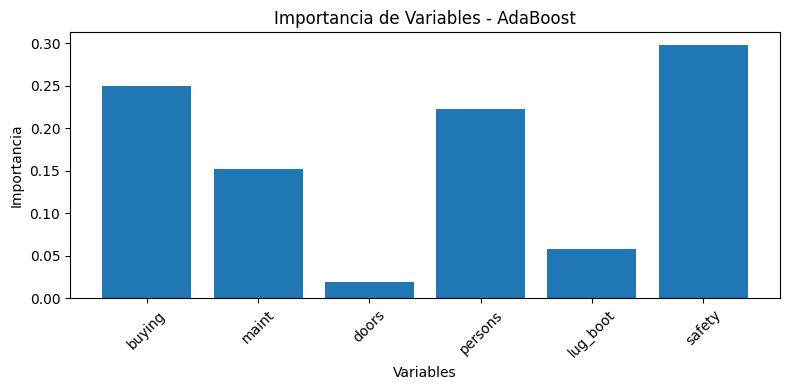

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'

In [71]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce

# 1. Cargar datos
df = pd.read_csv('car.data', header=None)
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = columns

# 2. Dividir variables
X = df.drop('class', axis=1)
y = df['class']

# 3. Separar conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Codificar variables categóricas usando OrdinalEncoder
encoder = ce.OrdinalEncoder(cols=X.columns)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_encoded = encoder.transform(X)

# 5. Modelo base y AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier(estimator=base_model, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost.fit(X_train_encoded, y_train)

# 6. Evaluación
y_pred = adaboost.predict(X_test_encoded)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 7. Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - AdaBoost")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# 8. ROC AUC para multiclase
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = adaboost.predict_proba(X_test_encoded)
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print(f"Multiclass ROC AUC score: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC por Clase")
plt.legend()
plt.grid(True)
plt.show()

# 9. Búsqueda de Hiperparámetros
param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}
grid = GridSearchCV(AdaBoostClassifier(estimator=base_model, random_state=42),
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_encoded, y_train)
print("\nMejores Hiperparámetros:", grid.best_params_)
print("Precisión con los mejores parámetros:",
      accuracy_score(y_test, grid.best_estimator_.predict(X_test_encoded)))

# 10. Validación cruzada
scores = cross_val_score(adaboost, X_encoded, y, cv=5, scoring='accuracy')
print("\nPrecisión Promedio con Validación Cruzada:", np.mean(scores))

# 11. Importancia de variables
feat_importance = adaboost.feature_importances_
plt.figure(figsize=(8, 4))
plt.bar(X.columns, feat_importance)
plt.title("Importancia de Variables - AdaBoost")
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. SHAP para Interpretabilidad
import shap

# Usamos TreeExplainer en lugar de Explainer debido a que AdaBoost usa un modelo basado en árboles (DecisionTreeClassifier)
explainer = shap.TreeExplainer(adaboost.estimator)  # Usamos el árbol base en AdaBoost
shap_values = explainer.shap_values(X_test_encoded[:100])  # Usamos las primeras 100 filas para visualizar

# Resumen de SHAP
shap.summary_plot(shap_values, X_test_encoded[:100], feature_names=X.columns)

